# ADVANCED


## Table of Content


- [1. Overview](#1)
- [2. Function](#2)
- [3. Load df_dict and train_data from baseline](#3)
- [4. Feature Engineering](#4)
    - [4.1 High Pass Count Feature](#41)
    - [4.2 Speed Difference](#42)
    - [4.3 Mounted yes/no](#43)
    - [4.4 Transform Second to Categorical](#44)
- [4. New Feature EDA](#5)
    - [4.1 Plot](#51)
    - [4.2 Corr](#52)
- [5. Model Tuning](#6)
    - [5.1 New Feature](#61)
    - [5.2 Combined Feature](#62)
    - [5.3 Oversampling/Undersampling](#63)
    - [5.4 Stacking](#64)
    - [5.5 Probability Cut Off](#65)
- [6. Summary](#7)


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import gc
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import copy
import pickle
import swifter
import sys
pd.set_option('display.max_columns', 500)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, classification_report
from sklearn.ensemble import RandomForestClassifier
import shap

/home/kurniawanekn/.local/lib/python3.5/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


<a id="2"></a>

## 2. Function

Based on baseline notebook I learnt that acceleration and gyro data is varies for each bookingID, I assume that this data dependant to to the smartphone driver. Either not calibrated, erronous data kinda like outlier, or we don't know how the driver put its phone while driving. So, normalization is a hard thing to do if we just rely on mean and std, the method isn't robust to outlier. To address that problem we're gonna use a simplified version of Low/High Pass Filter. We're gonna create robust handcrafted feature for each accelerometer & gyroscope data based on its median and MAD.

Median (Robust mean estimation)

MAD (Median Absolute Deviation, robust alternative to std)

Using this method we know a 'normalized' version of how many the data get too far from its middle point.

In [2]:
def adv_statform(df_dict,data,booking_id,var):
    """
    Generate statistical measurement of a variable with the same bookingID.
    Use this in pandas apply.
    
    Input:
    booking_id      bookingID
    df_dict         list containing dataframe per bookingID
    data df         label data
    """
#     booking_id = booking_id.bookingID
    var_series = df_dict[booking_id][var]
    med = data.loc[data.bookingID == booking_id]['median_'+var].values[0]
    mad = abs(var_series-med).mean()
    
    cnt = var_series.count()
    
    cut1 = 0
    cut2 = 0
    cut3 = 0
## ver 4 gyro
    if var=='gyro_x' or var=='gyro_y' or var=='gyro_z':
        cut1 = len(np.where((abs(med-var_series)>(0.1)) & (abs(med-var_series)<=(0.2)))[0])
        cut2 = len(np.where((abs(med-var_series)>(0.2)) & (abs(med-var_series)<=(0.4)))[0])
        cut3 = len(np.where(abs(med-var_series)>(0.4))[0])
    
    if var=='acceleration_x' or var=='acceleration_y' or var=='acceleration_z':
        cut1 = len(np.where((abs(med-var_series)>(1.0)) & (abs(med-var_series)<=(2.0)))[0])
        cut2 = len(np.where((abs(med-var_series)>(2.0)) & (abs(med-var_series)<=(4.0)))[0])
        cut3 = len(np.where(abs(med-var_series)>(4.0))[0])
    
#     return cut1,cut2,cut3,cut4,cut5
    return mad,cut1,cut2,cut3

In [3]:
def ediff(df_dict,booking_id,var):
    #booking_id = booking_id.bookingID
    var_series = df_dict[booking_id][var]
    ediff = np.ediff1d(var_series)
    return ediff.sum()/var_series.count()

In [4]:
Path = '/jet/prs/aiforsea/' # don't forget the slash at the end

def save_obj(obj, name ):
    with open(Path+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(Path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

<a id="3"></a>



## 3. Load df_dict and train_data from baseline



In [46]:
train_data = load_obj('train_data')
df_dict = load_obj('df_dict')
#train_data_adv = load_obj('train_data_adv')

<a id="4"></a>


## 4. Feature Engineering



<a id="41"></a>


### 4.1 High Pass Count Feature



In [47]:
%%time

# High & Low Pass Filter


train_data_adv = train_data[['bookingID','label']].copy()

cols = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'] 

for col in cols:
    mad = 'mad_' + col
    cut1 = 'count1_' + col
    cut2 = 'count2_' + col
    cut3 = 'count3_' + col
    
    train_data_adv[[mad,cut1, cut2, cut3]] = train_data_adv.apply(lambda x:adv_statform(df_dict,train_data,x['bookingID'],col), axis = 1, result_type='expand')



CPU times: user 12min 45s, sys: 144 ms, total: 12min 45s
Wall time: 12min 44s


<a id="42"></a>


### 4.2 Speed Difference


In [48]:
%%time
train_data_adv['speed_diff'] = train_data_adv.apply(lambda x:ediff(df_dict,x['bookingID'],'Speed'), axis=1)

CPU times: user 4.48 s, sys: 8 ms, total: 4.49 s
Wall time: 4.48 s


<a id="43"></a>


### 4.3 Mounted yes/no

In [49]:
train_data_adv['mounted'] = np.where((train_data['median_acceleration_y']>7) & (train_data['median_acceleration_y']<13), 1, 0)

In [50]:
train_data_adv.mounted.value_counts(normalize=True)

1    0.711213
0    0.288787
Name: mounted, dtype: float64

In [305]:
save_obj(train_data_adv,'train_data_adv')

<a id="44"></a>


### 4.4 Transform Second to Categorical
max_second from previous experiment in baseline is too predictive it's suspicious. For advanced model we created a equal size binning 'trip_duration' for max_second.

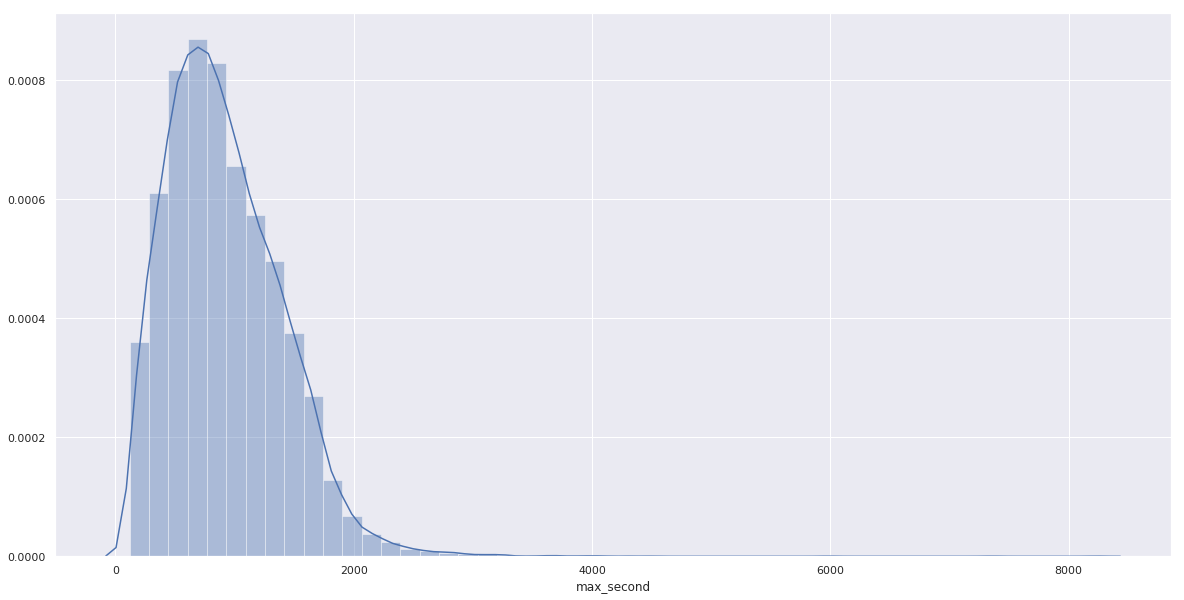

In [65]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(train_data['max_second'])

# We can see the peak around 900, down to 2000 and small amount of data in 8000


In [176]:
# Equal binning
cut = 4
train_data_adv['trip_duration'] = pd.qcut(train_data.max_second,cut,labels=[1,2,3,4])
print(pd.qcut(train_data.max_second,cut).value_counts())

(554.0, 854.0]      5096
(118.999, 554.0]    5024
(1217.0, 8235.0]    4998
(854.0, 1217.0]     4876
Name: max_second, dtype: int64


In [178]:
train_data_adv.groupby(['trip_duration']).mean()
# 1 (118.999, 554.0]
# 2 (554.0, 854.0] 
# 3 (854.0, 1217.0] 
# 4 (1217.0, 8235.0]

,bookingID,label,mad_acceleration_x,count1_acceleration_x,count2_acceleration_x,count3_acceleration_x,mad_acceleration_y,count1_acceleration_y,count2_acceleration_y,count3_acceleration_y,mad_acceleration_z,count1_acceleration_z,count2_acceleration_z,count3_acceleration_z,mad_gyro_x,count1_gyro_x,count2_gyro_x,count3_gyro_x,mad_gyro_y,count1_gyro_y,count2_gyro_y,count3_gyro_y,mad_gyro_z,count1_gyro_z,count2_gyro_z,count3_gyro_z,speed_diff,mounted
trip_duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,8.137476e+11,0.116441,0.572955,44.100916,13.716361,1.449045,0.464267,30.666401,6.657842,2.157643,0.720201,65.587381,18.637540,2.857683,0.051530,32.086186,12.439889,3.570462,0.075343,40.901672,23.247611,7.892516,0.038629,21.051154,6.141919,1.956409,-0.000786,0.714570
2,8.152482e+11,0.199568,0.579622,79.746272,24.240581,2.894427,0.490142,58.139129,12.930141,4.641287,0.737662,118.478807,33.684458,5.809851,0.052852,58.523940,23.509223,7.434655,0.077673,73.774137,40.260400,14.720565,0.039937,38.016091,11.281397,4.263540,0.002379,0.714678
3,8.108891e+11,0.251846,0.602433,117.048811,36.022149,5.650943,0.533351,89.316038,20.935398,8.939500,0.769629,170.670427,50.965751,10.983798,0.056253,88.953856,36.356850,12.210829,0.075735,106.305783,54.843724,20.544504,0.042277,56.185603,17.757383,7.718417,0.002190,0.706727
4,8.244928e+11,0.432773,0.633134,175.568027,54.194878,11.965386,0.588482,137.657263,35.887355,18.915566,0.806460,248.377951,75.320928,22.179272,0.059730,136.174470,55.547019,20.445178,0.075665,155.139256,74.816126,29.849540,0.045326,83.689076,27.675270,13.794718,0.001688,0.708683


In [195]:
train_data_adv['trip_duration'] = train_data_adv['trip_duration'].astype('int64')
train_data_adv.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19994 entries, 0 to 20017
Data columns (total 29 columns):
bookingID                19994 non-null int64
label                    19994 non-null int64
mad_acceleration_x       19994 non-null float64
count1_acceleration_x    19994 non-null float64
count2_acceleration_x    19994 non-null float64
count3_acceleration_x    19994 non-null float64
mad_acceleration_y       19994 non-null float64
count1_acceleration_y    19994 non-null float64
count2_acceleration_y    19994 non-null float64
count3_acceleration_y    19994 non-null float64
mad_acceleration_z       19994 non-null float64
count1_acceleration_z    19994 non-null float64
count2_acceleration_z    19994 non-null float64
count3_acceleration_z    19994 non-null float64
mad_gyro_x               19994 non-null float64
count1_gyro_x            19994 non-null float64
count2_gyro_x            19994 non-null float64
count3_gyro_x            19994 non-null float64
mad_gyro_y               19994 

<a id="5"></a>


## 5. New Feature EDA

<a id="51"></a>


### 5.1 Plot

In [12]:
# to do
g = sns.pairplot(iris, hue="species", markers=["o", "s", "D"])


In [196]:
train_data_adv.groupby('label').mean()

,bookingID,mad_acceleration_x,count1_acceleration_x,count2_acceleration_x,count3_acceleration_x,mad_acceleration_y,count1_acceleration_y,count2_acceleration_y,count3_acceleration_y,mad_acceleration_z,count1_acceleration_z,count2_acceleration_z,count3_acceleration_z,mad_gyro_x,count1_gyro_x,count2_gyro_x,count3_gyro_x,mad_gyro_y,count1_gyro_y,count2_gyro_y,count3_gyro_y,mad_gyro_z,count1_gyro_z,count2_gyro_z,count3_gyro_z,speed_diff,mounted,trip_duration
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.054674e+11,0.571366,94.780148,27.244584,2.808946,0.476410,71.639491,14.690687,4.221519,0.717765,139.294514,38.297847,5.913072,0.051710,72.466169,27.809146,7.356976,0.072507,86.412839,43.339244,14.496900,0.037746,44.547897,12.495234,3.781615,0.001341,0.720485,2.325245
1,8.481206e+11,0.673559,131.057881,46.115562,13.468856,0.645998,99.979371,32.127378,21.889445,0.879955,183.718005,63.238133,23.967755,0.065158,97.479071,44.068896,21.467655,0.086946,115.941718,62.723813,29.353695,0.052885,64.784098,25.197677,16.304626,0.001437,0.683357,2.995193


In [13]:
# plot max second to label

<a id="52"></a>


### 5.2 Corr

In [14]:
# to do

<a id="6"></a>


## 6. Model Tuning

<a id="61"></a>


### 6.1 XGBoost New Feature

Pretty promising

[0]	validation_0-auc:0.675289	validation_1-auc:0.675067
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.680944	validation_1-auc:0.680963
[2]	validation_0-auc:0.68147	validation_1-auc:0.681459
[3]	validation_0-auc:0.681485	validation_1-auc:0.681432
[4]	validation_0-auc:0.682826	validation_1-auc:0.682804
[5]	validation_0-auc:0.692364	validation_1-auc:0.689088
[6]	validation_0-auc:0.693073	validation_1-auc:0.689287
[7]	validation_0-auc:0.693642	validation_1-auc:0.689468
[8]	validation_0-auc:0.697779	validation_1-auc:0.697053
[9]	validation_0-auc:0.697974	validation_1-auc:0.697401
[10]	validation_0-auc:0.69853	validation_1-auc:0.696658
[11]	validation_0-auc:0.698825	validation_1-auc:0.696874
[12]	validation_0-auc:0.699928	validation_1-auc:0.69757
[13]	validation_0-auc:0.700365	validation_1-auc:0.698124
[14]	validation_0-auc:0.701989	validation_1-auc:0.699231
[

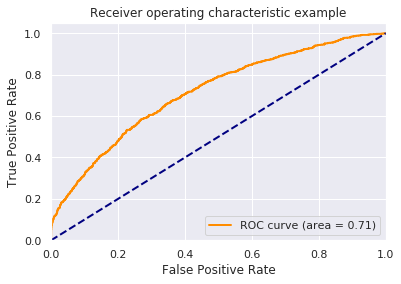

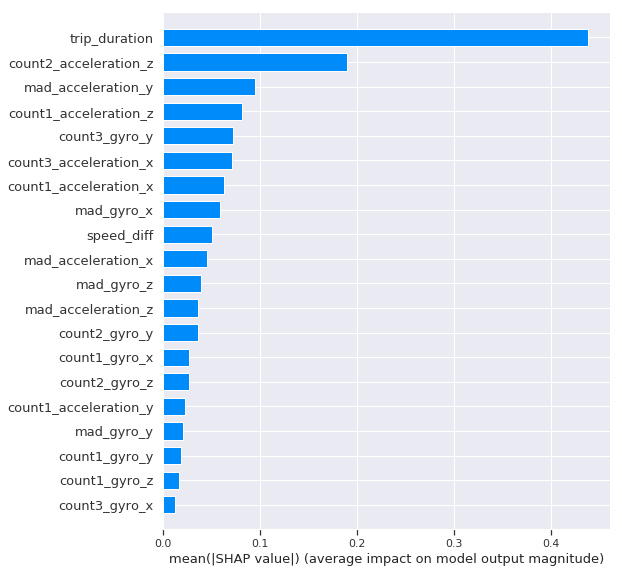

In [201]:
X = train_data_adv.drop('label', axis=1)

# drop column that didn't make any sense
X.drop('bookingID', axis=1, inplace=True)
#X.drop(['mean_second','std_second','min_second'], axis=1, inplace=True) # no meaning, represented by max second
#X.drop(['std_Bearing','max_Bearing','min_Bearing','mean_Bearing'], axis=1, inplace=True) # depends on other variable
#X.drop(['min_Speed'], axis=1, inplace=True) # all 0 

#X.drop(['mean_Speed','max_Speed','max_second'], axis=1, inplace=True)





Y = train_data_adv['label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


model = XGBClassifier(n_estimators=100, objective= 'binary:logistic')
#model = DecisionTreeClassifier()
#model = LogisticRegression(class_weight='balanced')
#model = RandomForestClassifier()

eval_set  = [(X_train,y_train), (X_test,y_test)]
model.fit(X_train, y_train, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=30)
#model.fit(X_train, y_train)


#model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print("ROC_AUC: %.2f%%" % (roc_auc_score(y_test.values, y_scores[:,1])*100))
print(classification_report(y_test, y_pred))





# Compute ROC curve and ROC area for each class
n_classes = 2


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.values, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.values, y_scores[:, i])
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

<a id="62"></a>


### 6.2 XGBoost Combined Feature
We tried to use new 'trip_duration' feature, but the result on test dataset is considerably lower. Final model will use 'max_second'.



[0]	validation_0-auc:0.684817	validation_1-auc:0.679045
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.686838	validation_1-auc:0.680035
[2]	validation_0-auc:0.688403	validation_1-auc:0.681881
[3]	validation_0-auc:0.705774	validation_1-auc:0.698011
[4]	validation_0-auc:0.709521	validation_1-auc:0.702685
[5]	validation_0-auc:0.71334	validation_1-auc:0.706502
[6]	validation_0-auc:0.714256	validation_1-auc:0.706507
[7]	validation_0-auc:0.715267	validation_1-auc:0.707381
[8]	validation_0-auc:0.717107	validation_1-auc:0.709974
[9]	validation_0-auc:0.719165	validation_1-auc:0.711382
[10]	validation_0-auc:0.720136	validation_1-auc:0.713657
[11]	validation_0-auc:0.721958	validation_1-auc:0.714995
[12]	validation_0-auc:0.72287	validation_1-auc:0.716018
[13]	validation_0-auc:0.724108	validation_1-auc:0.715887
[14]	validation_0-auc:0.725085	validation_1-auc:0.718417


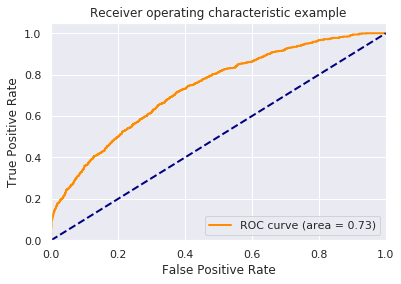

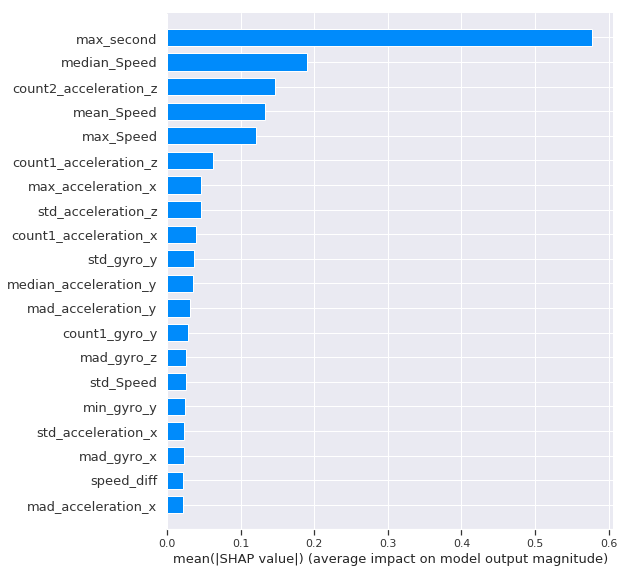

CPU times: user 13.8 s, sys: 412 ms, total: 14.2 s
Wall time: 13.6 s


In [228]:
%%time
#X = data_.drop('label', axis=1)
X = pd.merge(train_data, train_data_adv, on=['bookingID'])
X = X.drop('label', axis=1)
# drop column that didn't make any sense
X.drop('bookingID', axis=1, inplace=True)

X.drop(['median_second','mean_second','std_second','min_second'], axis=1, inplace=True) # no meaning, represented by max second
X.drop(['min_Speed'], axis=1, inplace=True) # all 0 

#X.drop(['mean_Speed','max_Speed','max_second'], axis=1, inplace=True)
X.drop(['trip_duration'], axis=1, inplace=True)






Y = train_data_adv['label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


model = XGBClassifier(n_estimators=10000, objective= 'binary:logistic')
#model = DecisionTreeClassifier()
#model = LogisticRegression()
#model = RandomForestClassifier()

eval_set  = [(X_train,y_train), (X_test,y_test)]
model.fit(X_train, y_train, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=30)

#model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print("ROC_AUC: %.2f%%" % (roc_auc_score(y_test.values, y_scores[:,1])*100))
print(classification_report(y_test, y_pred))





# Compute ROC curve and ROC area for each class
n_classes = 2


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.values, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.values, y_scores[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

<a id="63"></a>


### 6.3 Oversampling/Undersampling

In [ ]:
# not that effective

<a id="64"></a>


### 6.4 Stacking


In [276]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

models=[
        ######## First level ########
        [RandomForestClassifier (n_estimators=100, max_depth=5, max_features='auto', random_state=1),
        GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, max_features='auto', random_state=1),
        #DecisionTreeClassifier(),
        LogisticRegression(random_state=1, solver='liblinear',class_weight='balanced'),
        LogisticRegression(random_state=1, solver='liblinear'),
        ],
        ######## Second level ########
        [LogisticRegression(random_state=1, solver='liblinear')]
        ]

# add XGBOOST

In [287]:
from pystacknet.pystacknet import StackNetClassifier

modelx=StackNetClassifier(models, metric="auc", folds=4,
    restacking=False,use_retraining=True, use_proba=True, 
    random_state=12345,n_jobs=1, verbose=1)

modelx.fit(X_train,y_train)
# model = RandomForestClassifier() # Backup just in case your pystacknet couldn't be installed properly



preds=modelx.predict_proba(X_test)
preds_train=modelx.predict_proba(X_train)

====================== Start of Level 0 ======================
Input Dimensionality 61 at Level 0 
4 models included in Level 0 
Fold 1/4 , model 0 , auc===0.681690 
Fold 1/4 , model 1 , auc===0.709443 
Fold 1/4 , model 2 , auc===0.711537 
Fold 1/4 , model 3 , auc===0.710018 
=========== end of fold 1 in level 0 ===========
Fold 2/4 , model 0 , auc===0.712019 
Fold 2/4 , model 1 , auc===0.729517 
Fold 2/4 , model 2 , auc===0.734392 
Fold 2/4 , model 3 , auc===0.733579 
=========== end of fold 2 in level 0 ===========
Fold 3/4 , model 0 , auc===0.705089 
Fold 3/4 , model 1 , auc===0.719294 
Fold 3/4 , model 2 , auc===0.727612 
Fold 3/4 , model 3 , auc===0.728972 
=========== end of fold 3 in level 0 ===========
Fold 4/4 , model 0 , auc===0.688885 
Fold 4/4 , model 1 , auc===0.711726 
Fold 4/4 , model 2 , auc===0.706407 
Fold 4/4 , model 3 , auc===0.706471 
=========== end of fold 4 in level 0 ===========
Level 0, model 0 , auc===0.696921 
Level 0, model 1 , auc===0.717495 
Level 0, mode

<a id="65"></a>

### 6.5 Probability Cut Off

TRAIN
Accuracy  : 0.81300406
Recall    : 0.42935323
Precision : 0.71234007
AUC score : 0.81252767
Confusion Matrix : 
 [[11278   697]
 [ 2294  1726]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     11975
           1       0.71      0.43      0.54      4020

    accuracy                           0.81     15995
   macro avg       0.77      0.69      0.71     15995
weighted avg       0.80      0.81      0.80     15995


TEST
Accuracy  : 0.77794449
Recall    : 0.35354573
Precision : 0.57048093
AUC score : 0.74364585
Confusion Matrix : 
 [[2767  259]
 [ 629  344]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3026
           1       0.57      0.35      0.44       973

    accuracy                           0.78      3999
   macro avg       0.69      0.63      0.65      3999
weighted avg       0.76      0.78      0.76      3999



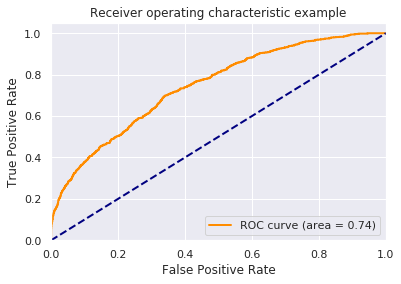

In [307]:
from sklearn.metrics import confusion_matrix

t = 0.4
t1 = 1 - t
pred = pd.DataFrame({'pred0':preds[:,0],'pred1':preds[:,1]})
pred['pred'] = np.where(pred['pred0']<=t1, '1', '0').astype(int)

pred_train = pd.DataFrame({'pred0':preds_train[:,0],'pred1':preds_train[:,1]})
pred_train['pred'] = np.where(pred_train['pred0']<=t1, '1', '0').astype(int)

print ("TRAIN")
print ("Accuracy  : %.8f" % accuracy_score(y_train, pred_train.pred.values))
print ("Recall    : %.8f" % recall_score(y_train, pred_train.pred.values))
print ("Precision : %.8f" % precision_score(y_train, pred_train.pred.values))
print ("AUC score : %.8f" % roc_auc_score(y_train, preds_train[:,1]))
print ("Confusion Matrix : \n", confusion_matrix(y_train, pred_train.pred.values))
print(classification_report(y_train, pred_train.pred.values))



print ("\nTEST")
print ("Accuracy  : %.8f" % accuracy_score(y_test, pred.pred.values))
print ("Recall    : %.8f" % recall_score(y_test, pred.pred.values))
print ("Precision : %.8f" % precision_score(y_test, pred.pred.values))
print ("AUC score : %.8f" % roc_auc_score(y_test, preds[:,1]))
print ("Confusion Matrix : \n", confusion_matrix(y_test, pred.pred.values))
print (classification_report(y_test, pred.pred.values))

pd.Series(pred.pred.values).value_counts(normalize=True) # same distribution


# Compute ROC curve and ROC area for each class
n_classes = 2


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.values, preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.values, preds[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



Same distribution

<a id="7"></a>


## 7. Summary of Advanced Model 

Using the combined feature from baseline model and new feature in this notebook (high pass count, speed diff, etc) the AUC of baseline xgb model increased from 0.715 to 0.734.
We further improve the AUC by Stacking, advanced model now achieve 0.743 AUC on test data & 0.81 on train data.

Final model is based on feature from baseline and advanced.ipnyb. The final model trained with 100% data in PREDICT notebook.